In [1]:
import os
import glob
import torch
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src/models/")
from swin import BaseSwinUnet
from restormer import BaseRestormer
from bunet import BaseUnet
from noiseadding import build_noise_transforms, CombinedTransforms
from data import get_train_val_dataset, get_dataset, get_train_val_dataset
from metrics import ConfusionMatrix, RMSE
import torchvision
from numba import cuda

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def build_model(model, problem):
    if model == 'restormer':
        if problem == 'deraining':
            model = BaseRestormer(inp_channels=3, out_channels=3, dim=24)
        elif problem == 'denoise':
            model = BaseRestormer(inp_channels=1, out_channels=1, dim=24, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseRestormer(inp_channels=1, out_channels=2, dim=24)
        else:
            raise ValueError('Undefined problem!')
    elif model == 'swin':
        if problem == 'deraining':
            model = BaseSwinUnet(in_chans=3, num_classes=3, embed_dim=48)
        elif problem == 'denoise':
            model = BaseSwinUnet(in_chans=1, num_classes=1, embed_dim=48, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseSwinUnet(in_chans=1, num_classes=2, embed_dim=48)
        else:
            raise ValueError('Undefined problem!')
    elif model == 'unet':
        if problem == 'deraining':
            model = BaseUnet(in_channels=3, out_channels=3)
        elif problem == 'denoise':
            model = BaseUnet(in_channels=1, out_channels=1, activation='tanh')
        elif problem == 'firstbreak':
            model = BaseUnet(in_channels=1, out_channels=2)
        else:
            raise ValueError('Undefined problem!')
    else:
        raise ValueError('Undefined model!')
    return model

In [5]:
model_type='unet'
problem='firstbreak'
if problem == 'firstbreak':
    metrics = ConfusionMatrix(2, ["empty", "firstbreak"])
else:
    metrics = RMSE()
noise_type = -1
noise_scale = 0.0
batch_size=8
workers=4
METADATA = '../metadata/'

In [6]:
model = build_model(model_type, problem)
device = torch.device("cpu")
model.to(device)
weight_file = 'unet_firstbreak_noisetype_-1_noisescale_0.0'
save_path = os.path.join(METADATA, weight_file + '.pkl')
model.load_state_dict(torch.load(save_path))
model.eval()

Using cache found in /home/makam0a/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


BaseUnet(
  (unet): UNet(
    (encoder1): Sequential(
      (enc1conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu1): ReLU(inplace=True)
      (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc1relu2): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (encoder2): Sequential(
      (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (enc2relu1): ReLU(inplace=True)
      (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (enc2norm2): BatchNo

In [7]:
def evaluate(model, loader, metrics):
    metrics.reset()
    for i, (sample) in enumerate(loader):
        x, y = sample['input'].float(), sample['target'].numpy()
        with torch.no_grad():
            y_pred = model(x)
            if problem == 'firstbreak':
                y_pred = torch.argmax(y_pred, dim=1) # get the most likely prediction
        metrics.add_batch(y, y_pred.detach().cpu().numpy())
        print('_', end='')
    return metrics.get()

def evaluate_robustness(model, metrics):
    robustness = np.zeros([4,4])
    for i, noise_type in enumerate(range(4)):
        for j, noise_scale in enumerate([0.25,0.5,1.0,2.0]):
            noise_transforms = build_noise_transforms(noise_type=noise_type, scale=noise_scale)
            denoise_dataset = get_dataset('firstbreak', noise_transforms=noise_transforms)
            _, val_dataset = get_train_val_dataset(denoise_dataset)
            valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)
            robustness[i, j] = evaluate(model, valid_loader, metrics)
            print(noise_type, noise_scale, robustness[i, j])
    return robustness

In [8]:
noise_transforms = build_noise_transforms(noise_type=-1, scale=0)
denoise_dataset = get_dataset('firstbreak', noise_transforms=noise_transforms)
train_dataset, val_dataset = get_train_val_dataset(denoise_dataset)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

evaluate(model, valid_loader, metrics)

___________________________

0.9996237064794107

In [61]:
robustness = evaluate_robustness(model, metrics)
np.save(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'),np.array(robustness))

___________________________0 0.25 0.3578163323416848
___________________________0 0.5 0.3560139472063022
___________________________0 1.0 0.35224260776552563
___________________________0 2.0 0.3520435422671147
___________________________1 0.25 0.3585580292324308
___________________________1 0.5 0.3548119071079891
___________________________1 1.0 0.35676015078392054
___________________________1 2.0 0.35255833265528175
___________________________2 0.25 0.3555927960516808
___________________________2 0.5 0.35291179466804573
___________________________2 1.0 0.3521714130980177
___________________________2 2.0 0.35760073529909403
___________________________3 0.25 0.35752323858471
___________________________3 0.5 0.354868611592725
___________________________3 1.0 0.3537130131397619
___________________________3 2.0 0.3534624405531652


In [64]:
np.load(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'))

array([[0.35781633, 0.35601395, 0.35224261, 0.35204354],
       [0.35855803, 0.35481191, 0.35676015, 0.35255833],
       [0.3555928 , 0.35291179, 0.35217141, 0.35760074],
       [0.35752324, 0.35486861, 0.35371301, 0.35346244]])

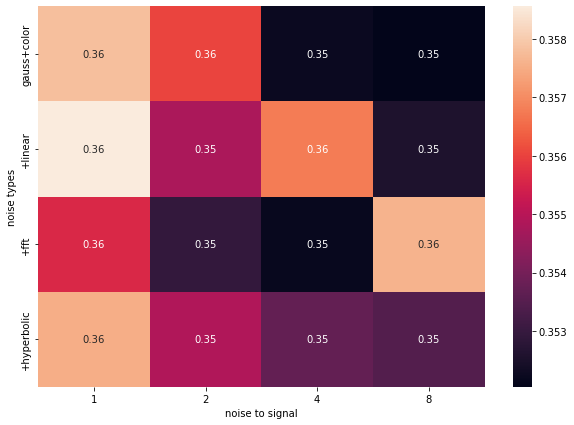

In [65]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(robustness, index = [i for i in ['gauss+color', '+linear', '+fft', '+hyperbolic']],
                  columns = [i for i in [1,2,4,8]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('noise to signal')
plt.ylabel('noise types')
plt.show()

In [ ]:
for noise_type in [0,1,2,3]:
    for noise_scale in [0.25,0.5,1.0,2.0]:
        model = build_model(model_type, problem)
        device = torch.device("cpu")
        model.to(device)
        weight_file = f'unet_firstbreak_noisetype_{noise_type}_noisescale_{noise_scale}'
        save_path = os.path.join(METADATA, weight_file + '.pkl')
        model.load_state_dict(torch.load(save_path))
        model.eval()
        print(weight_file)
        robustness = evaluate_robustness(model, metrics)
        np.save(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'),np.array(robustness))

In [30]:
noise_type = 3
noise_scale = 2.0
weight_file = f'unet_firstbreak_noisetype_{noise_type}_noisescale_{noise_scale}'
robustness = np.load(os.path.join(METADATA, 'robustness_' + weight_file + '.npy'))

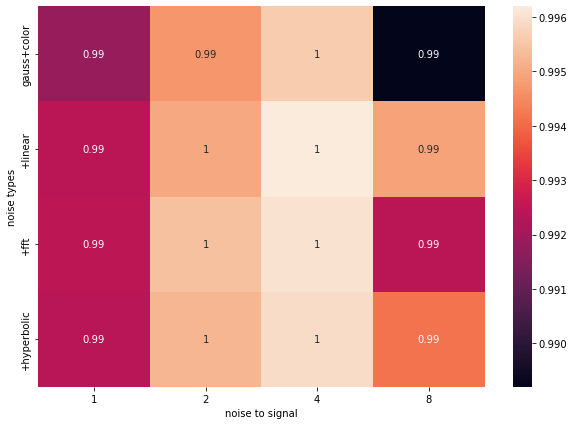

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(robustness, index = [i for i in ['gauss+color', '+linear', '+fft', '+hyperbolic']],
                  columns = [i for i in [1,2,4,8]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.xlabel('noise to signal')
plt.ylabel('noise types')
plt.show()